In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob as gb
from PIL import Image
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
def read_user_account(path):
    df = pd.read_json(path)
    return df

df = read_user_account('../../info/follow_user_account/user_account_using.json')
# df = read_user_account('../../info/follow_user_account/user_account.json')
df.head()

,user_id,user_name
0,1184799,三嶋くろね
1,1565632,カントク
2,216403,しらび


<class 'numpy.ndarray'>
(64, 64, 3)
uint8


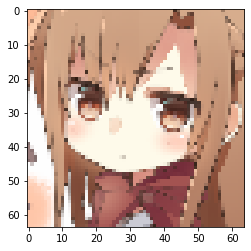

In [3]:
def read_illust(path):
    illust = cv2.imread(path)
    return illust

illust = read_illust('../../data/pixiv/interim/face/face_test/1184799/31105617_p0_1.png')
print(type(illust))
print(illust.shape)
print(illust.dtype)
plt.imshow(cv2.cvtColor(illust, cv2.COLOR_BGR2RGB))

In [4]:
def get_user_list():
    df_ac = read_user_account('../../info/follow_user_account/user_account_using.json')
    user_id_list = df_ac['user_id'].values
    user_name_list = df_ac['user_name'].values
    return user_id_list, user_name_list
    
user_id_list, user_name_list = get_user_list()
print(user_id_list, user_name_list)

[1184799 1565632  216403] ['三嶋くろね' 'カントク' 'しらび']


107
<class 'numpy.ndarray'>
(64, 64, 3)
uint8


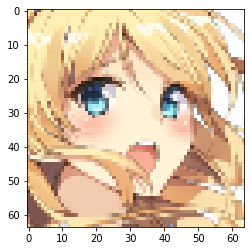

In [5]:
def read_illusts(path, user_id):
    illust_path_list = gb.glob(path + str(user_id) + '/*')
    illust_list = [read_illust(illust_path) for illust_path in illust_path_list]
    return illust_list

kurone = 1184799
illust_list = read_illusts('../../data/pixiv/interim/face/', kurone)
print(len(illust_list))
print(type(illust_list[0]))
print(illust_list[0].shape)
print(illust_list[0].dtype)
plt.imshow(cv2.cvtColor(illust_list[0], cv2.COLOR_BGR2RGB))

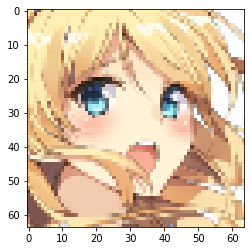

In [6]:
def read_illustrator(user_id_list):
    path = '../../data/pixiv/interim/face/'
    illustrator_illust_list = [read_illusts(path, user_id) for user_id in user_id_list]
    return illustrator_illust_list

illustrator_illust_list = read_illustrator(user_id_list) # イラストレータごとの全顔画像データ
plt.imshow(cv2.cvtColor(illustrator_illust_list[0][0], cv2.COLOR_BGR2RGB))

In [7]:
def make_dataset(illustrator_illust_list):
    illustrator_dataset_list = []
    for illusts in illustrator_illust_list:
        dataset_list = [illust.flatten() for illust in illusts] 
        illustrator_dataset_list.append(dataset_list)
    
    return illustrator_dataset_list

illustrator_dataset_list = make_dataset(illustrator_illust_list)

In [8]:
def make_merge_dataset(illustrator_dataset_list):
    merge_df = pd.DataFrame()

    kurone_df = pd.DataFrame(illustrator_dataset_list[0])
    kantoku_df = pd.DataFrame(illustrator_dataset_list[1])
    shirabi_df = pd.DataFrame(illustrator_dataset_list[2])
    kurone_df['labels'] = 'kurone'
    kantoku_df['labels'] = 'kantoku'
    shirabi_df['labels'] = 'shirabi'

    merge_df = pd.concat([merge_df, kurone_df], axis=0)
    merge_df = pd.concat([merge_df, kantoku_df], axis=0)
    merge_df = pd.concat([merge_df, shirabi_df], axis=0)

    return merge_df.reset_index(drop=True)

merge_df = make_merge_dataset(illustrator_dataset_list)
merge_df

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,labels
0,175,231,252,175,233,253,150,119,124,64,...,147,176,208,182,236,253,181,235,252,kurone
1,134,78,232,134,78,232,134,78,232,134,...,61,51,55,66,55,59,53,36,75,kurone
2,197,198,231,197,197,230,198,198,230,199,...,255,255,255,255,255,255,255,255,255,kurone
3,121,160,215,165,204,243,199,232,255,201,...,102,125,171,50,82,144,50,83,144,kurone
4,35,37,72,47,48,88,44,43,82,38,...,227,217,250,228,225,251,214,213,244,kurone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,88,55,49,87,56,51,78,51,49,48,...,35,34,50,26,41,65,25,49,87,shirabi
417,227,152,174,125,68,80,102,56,61,124,...,178,162,205,178,162,205,178,161,204,shirabi
418,21,21,31,22,22,33,22,22,33,22,...,25,24,29,25,24,28,25,24,29,shirabi
419,81,34,53,0,0,2,4,1,23,15,...,62,49,171,66,55,170,95,90,166,shirabi


In [9]:
def pca_illust(df):
    #主成分分析の実行
    pca = PCA(2)
    pca.fit(df.drop('labels', axis=1))
    # データを主成分空間に写像
    feature = pca.transform(df.drop('labels', axis=1))
    pca_df = pd.DataFrame(feature, columns=['pca1', 'pca2'])

    return pca_df

pca_df = pca_illust(merge_df)

In [10]:
# 正規化
def minmax_scaler(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    # 正規化したデータを新規のデータフレームに
    # df_minmax = pd.DataFrame(scaler.transform(df), columns=df.columns) 
    # 正規化したデータをリストに
    mc_list = scaler.fit_transform(df)
    return mc_list

# 標準化
def standard_scaler(df):
    scaler = StandardScaler()
    scaler.fit(df)
    # 標準化したデータを新規のデータフレームに
    df_std = pd.DataFrame(scaler.transform(df), columns=df.columns) 
    # 標準化したデータをリストに
    # std_list = scaler.fit_transform(df)
    return df_std

pca_df_std = standard_scaler(pca_df)
pca_df = pd.concat([pca_df_std, merge_df['labels']], axis=1)
pca_df

,pca1,pca2,labels
0,-1.240174,-0.451725,kurone
1,1.424070,-0.707343,kurone
2,-1.543694,0.292822,kurone
3,-1.662151,0.370275,kurone
4,0.699367,0.108506,kurone
...,...,...,...
416,0.159941,-2.403737,shirabi
417,0.179084,1.349572,shirabi
418,3.074670,-1.814365,shirabi
419,1.391755,-1.269175,shirabi


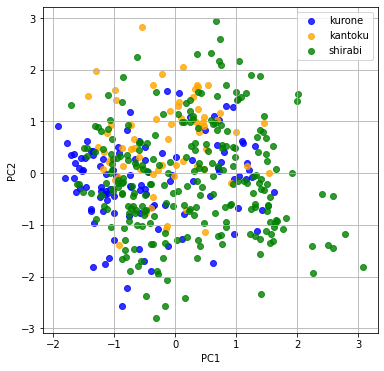

In [11]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))
plt.scatter(pca_df.loc[pca_df['labels']=='kurone', 'pca1'], pca_df.loc[pca_df['labels']=='kurone', 'pca2'], alpha=0.8, color='blue', label='kurone')
plt.scatter(pca_df.loc[pca_df['labels']=='kantoku', 'pca1'], pca_df.loc[pca_df['labels']=='kantoku', 'pca2'], alpha=0.8, color='orange', label='kantoku')
plt.scatter(pca_df.loc[pca_df['labels']=='shirabi', 'pca1'], pca_df.loc[pca_df['labels']=='shirabi', 'pca2'], alpha=0.8, color='green', label='shirabi')
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()